# Ranking Model Training and Evaluation

This notebook trains and evaluates the LGBMRanker model

In [1]:
import os
import sys
import json
import logging
import pickle
import pandas as pd
import numpy as np
from typing import Dict, Any, List, Tuple
import matplotlib.pyplot as plt
import yaml
from datetime import datetime
import time

In [2]:
import logging

logging.disable(logging.INFO)

In [3]:
PATH_NOTEBOOK = os.path.dirname(os.path.abspath("__file__"))
PATH_SRC = os.path.dirname(PATH_NOTEBOOK)
PATH_ROOT = os.path.dirname(PATH_SRC)
sys.path.append(PATH_ROOT)

# Path constants
PATH_DATA_PROCESSED = os.path.join(PATH_ROOT, "data", "processed")
PATH_RANKING_PROCESSED = os.path.join(PATH_DATA_PROCESSED, "ranking")
PATH_CONFIG = os.path.join(PATH_ROOT, "config", "ranking_config.yaml")

PATH_BASE_PROCESSED = os.path.join(PATH_DATA_PROCESSED, "base")
PATH_BASE_ARTIFACTS = os.path.join(PATH_BASE_PROCESSED, "artifacts")

PATH_MODEL_DIR = os.path.join(PATH_ROOT, "models", "ranking")
PATH_RESULTS_DIR = os.path.join(PATH_ROOT, "results", "ranking")
PATH_PLOTS_DIR = os.path.join(PATH_RESULTS_DIR, "plots")
PATH_GRID_SEARCH_DIR = os.path.join(PATH_RESULTS_DIR, "grid_search")

for dir_path in [PATH_MODEL_DIR, PATH_RESULTS_DIR, PATH_PLOTS_DIR, PATH_GRID_SEARCH_DIR]:
    os.makedirs(dir_path, exist_ok=True)

In [4]:
from src.models.ranking import (
    load_config, load_artifacts, load_data, train_lgbm_ranker,
    evaluate_lgbm_ranker, save_model_and_metrics, perform_grid_search,
    PARAM_GRIDS
)

from src.evaluation.visualization import (
    generate_feature_importance_plot, generate_learning_curve_plot,
    generate_ndcg_curve_plot, generate_visualizations, visualize_grid_search_results
)

from src.evaluation.analysis import (
    analyze_feature_importance, analyze_performance_by_group_size
)

from src.evaluation.comparison import compare_with_random_baseline

from src.prediction.ranking import run_inference

from src.utils.utils import setup_logger

## Load Configuration

In [5]:
config = load_config()
print("Configuration loaded with parameters:", json.dumps(config["parameters"], indent=4))

Configuration loaded with parameters: {
    "objective": "lambdarank",
    "metric": "ndcg",
    "eval_at": [
        1,
        3,
        5,
        10
    ],
    "boosting_type": "gbdt",
    "learning_rate": 0.05,
    "num_leaves": 125,
    "max_depth": 140,
    "min_data_in_leaf": 5,
    "min_sum_hessian_in_leaf": 0.001,
    "feature_fraction": 0.75,
    "bagging_fraction": 0.45,
    "bagging_freq": 5,
    "lambda_l1": 0.25,
    "lambda_l2": 0.25,
    "random_seed": 42,
    "force_row_wise": true
}


## Load Data

In [6]:
try:
    (X_train, groups_train, relevance_train, 
     X_val, groups_val, relevance_val, 
     X_test, groups_test, relevance_test,
     task_ids_train, task_ids_val, task_ids_test) = load_data()
    
    # Display sample of the training data
    print("\nSample training data features:")
    print(X_train.head().to_string(index=False))
    
    # Display relevance score distribution
    print("\nRelevance score distribution:")
    unique_relevance, counts = np.unique(relevance_train, return_counts=True)
    for rel, count in zip(unique_relevance, counts):
        print(f"  Relevance {rel}: {count} samples ({count/len(relevance_train)*100:.2f}%)")
    
    # Display feature names
    print("\nFeatures available for training:")
    for i, feature in enumerate(X_train.columns, 1):
        print(f"  {i}. {feature}")
    
    data_loaded = True
except Exception as e:
    print(f"Error loading data: {str(e)}")
    data_loaded = False


Sample training data features:
 TASK_ID  RATE_COST_RATIO  HISTORICAL_QUALITY  SECTOR_EXPERIENCE  TASK_TYPE_EXPERIENCE  LANGUAGE_PAIR_RARITY  EXPERIENCE_LEVEL  ONTIME_RATE  TASK_COMPLEXITY  URGENCY_COMPATIBILITY  SOURCE_LANG_ENCODED  TARGET_LANG_ENCODED  LANGUAGE_PAIR_ENCODED  TASK_TYPE_ENCODED  MANUFACTURER_ENCODED  MANUFACTURER_SECTOR_ENCODED  FORECAST  URGENCY_RATIO
10112607         0.712032            0.813146           1.000000              0.786365                   0.0          0.769939     0.761559         0.525321                    0.8                  7.0                 51.0                   84.0                7.0                1654.0                         18.0  1.609438       0.166747
10112607         1.000000            0.711326           1.000000              1.000000                   0.0          0.839886     0.591083         0.525321                    0.8                  7.0                 51.0                   84.0                7.0                1654.0   

## Grid Search Configuration

In [7]:
# Toggle grid search on/off
PERFORM_GRID_SEARCH = False  # Set to True to run grid search

# Choose grid size
GRID_SIZE = "M"  # Options: "S", "M", "L"

# Grid search implementation
best_gs_params = None

if PERFORM_GRID_SEARCH and data_loaded:
    try:
        print(f"Starting grid search with {GRID_SIZE} parameter grid...")
        
        active_param_grid = PARAM_GRIDS[GRID_SIZE]
        
        # Calculate total combinations
        total_combinations = np.prod([len(v) for v in active_param_grid.values()])
        print(f"Using {GRID_SIZE} grid with {total_combinations} combinations")
        
        # Get base parameters from config
        base_params = {k: v for k, v in config["parameters"].items() if k not in active_param_grid}
        
        # Run grid search
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        best_gs_model, best_gs_params, grid_results = perform_grid_search(
            X_train, relevance_train, groups_train,
            X_val, relevance_val, groups_val,
            active_param_grid, base_params,
            num_boost_round=config['training']['num_boost_round'],
            early_stopping_rounds=config['training']['early_stopping_rounds']
        )
        
        # Save results
        grid_results.to_csv(os.path.join(PATH_GRID_SEARCH_DIR, f"grid_search_results_{timestamp}.csv"), index=False)
        
        # Visualize results
        visualize_grid_search_results(grid_results, active_param_grid)
        
        print("\nGrid search completed successfully!")
        print(f"Best parameters: {best_gs_params}")
        print(f"Best validation combined score: {grid_results['combined_score'].max():.4f}")
        
        # Update config with best parameters
        config["parameters"].update(best_gs_params)
        print("\nConfiguration updated with best parameters from grid search")
        
    except Exception as e:
        print(f"Error during grid search: {str(e)}")
else:
    if not data_loaded:
        print("Data not loaded")
    elif not PERFORM_GRID_SEARCH:
        print("Grid search is disabled")

Grid search is disabled


## Train Model

In [8]:
if data_loaded:
    try:
        print("Starting model training...")
        
        # Train model
        model, training_history = train_lgbm_ranker(
            X_train, relevance_train, groups_train,
            X_val, relevance_val, groups_val,
            config
        )
        
        print(f"\nModel training completed successfully")
        print(f"Best iteration: {model.best_iteration}")
        
        model_trained = True
    except Exception as e:
        print(f"Error during training: {str(e)}")
        model_trained = False
else:
    print("Cannot train model as data loading failed")
    model_trained = False

Starting model training...
[LightGBM] [Info] Total Bins 2920
[LightGBM] [Info] Number of data points in the train set: 9142675, number of used features: 18
Training until validation scores don't improve for 10 rounds
[10]	train's ndcg@1: 0.822782	train's ndcg@3: 0.890023	train's ndcg@5: 0.913101	train's ndcg@10: 0.930602	validation's ndcg@1: 0.784506	validation's ndcg@3: 0.868364	validation's ndcg@5: 0.895719	validation's ndcg@10: 0.918649
[20]	train's ndcg@1: 0.839065	train's ndcg@3: 0.899865	train's ndcg@5: 0.920919	train's ndcg@10: 0.936962	validation's ndcg@1: 0.800392	validation's ndcg@3: 0.877981	validation's ndcg@5: 0.902921	validation's ndcg@10: 0.924338
[30]	train's ndcg@1: 0.849136	train's ndcg@3: 0.905651	train's ndcg@5: 0.925413	train's ndcg@10: 0.940602	validation's ndcg@1: 0.805871	validation's ndcg@3: 0.885133	validation's ndcg@5: 0.90746	validation's ndcg@10: 0.927207
[40]	train's ndcg@1: 0.861165	train's ndcg@3: 0.912616	train's ndcg@5: 0.931341	train's ndcg@10: 0.9455

## Evaluate Model

In [9]:
if model_trained:
    try:
        print("Evaluating model on test data...")
        
        # Evaluate model
        metrics = evaluate_lgbm_ranker(
            model, X_test, relevance_test, groups_test, config
        )

        print("\nEvaluation metrics:")
        for metric, value in metrics.items():
            print(f"  {metric}: {value:.4f}")

        evaluation_complete = True
    except Exception as e:
        print(f"Error during evaluation: {str(e)}")
        evaluation_complete = False
else:
    print("Cannot evaluate model as training failed")
    evaluation_complete = False

Evaluating model on test data...

Evaluation metrics:
  ndcg@1: 0.8841
  precision@1: 0.9934
  ndcg@3: 0.9293
  precision@3: 0.9915
  ndcg@5: 0.9463
  precision@5: 0.9895
  ndcg@10: 0.9625
  precision@10: 0.9771
  mrr: 0.9935


## Save Model and Visualizations

Saving model and generating visualizations...


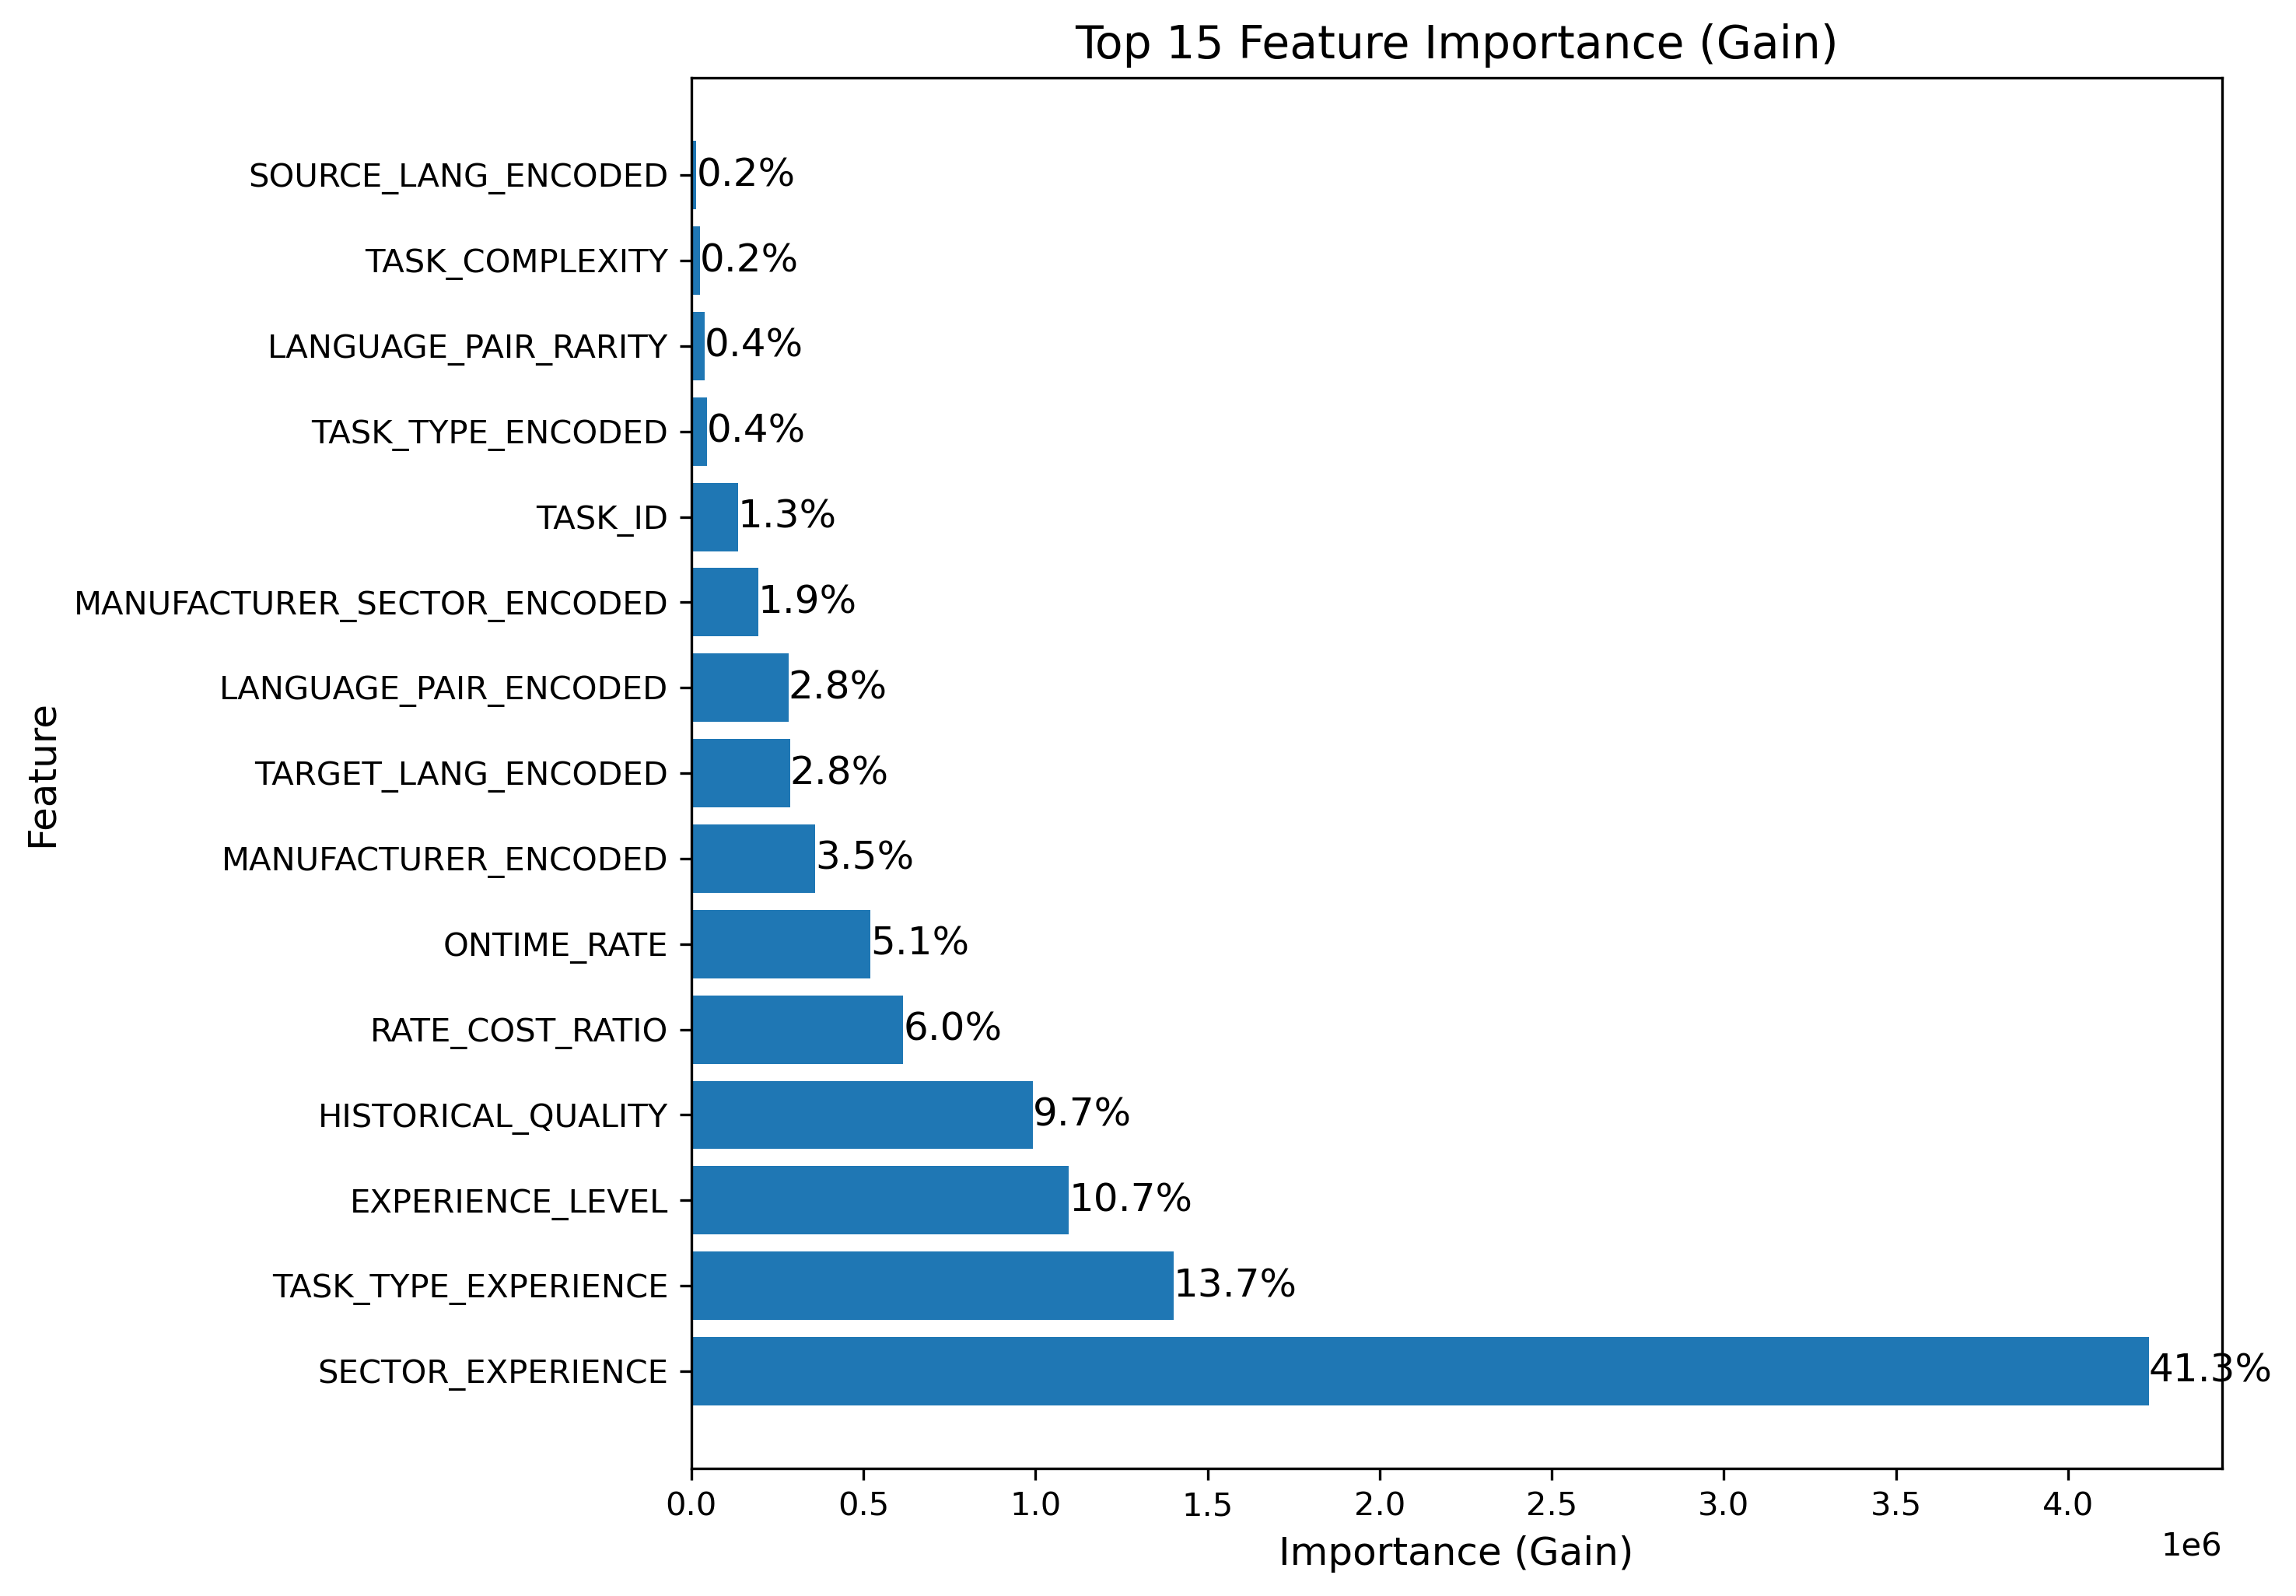

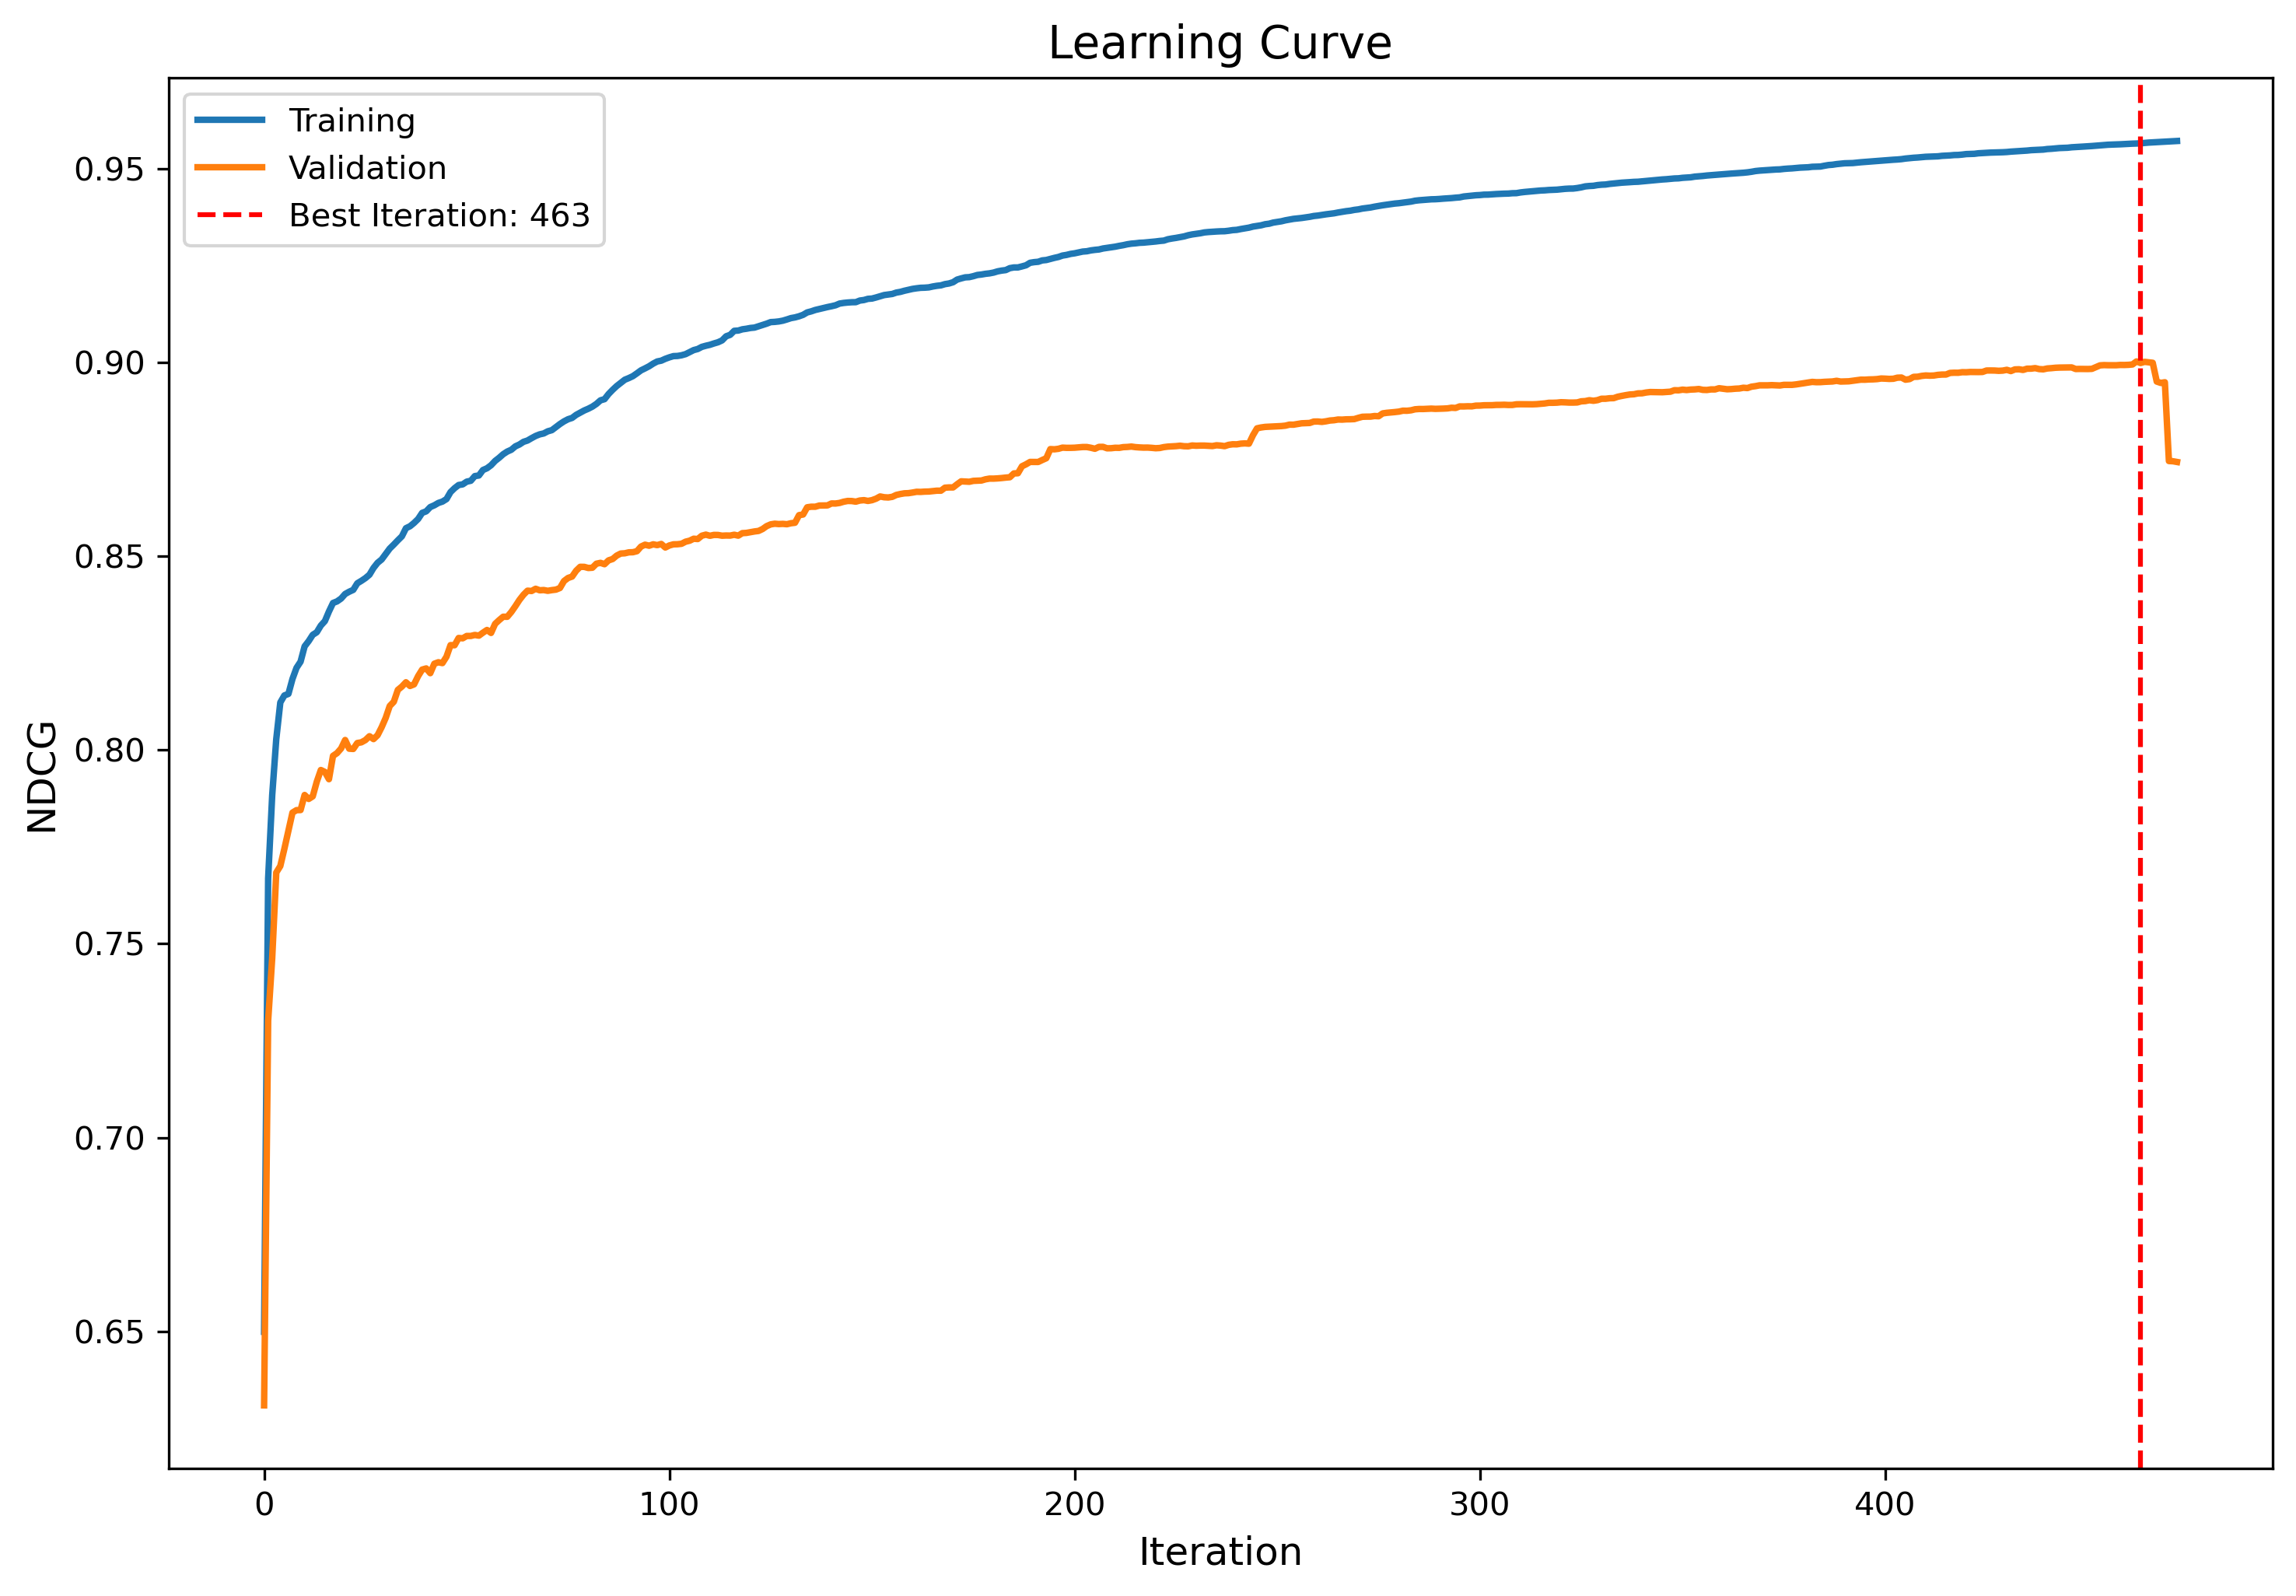

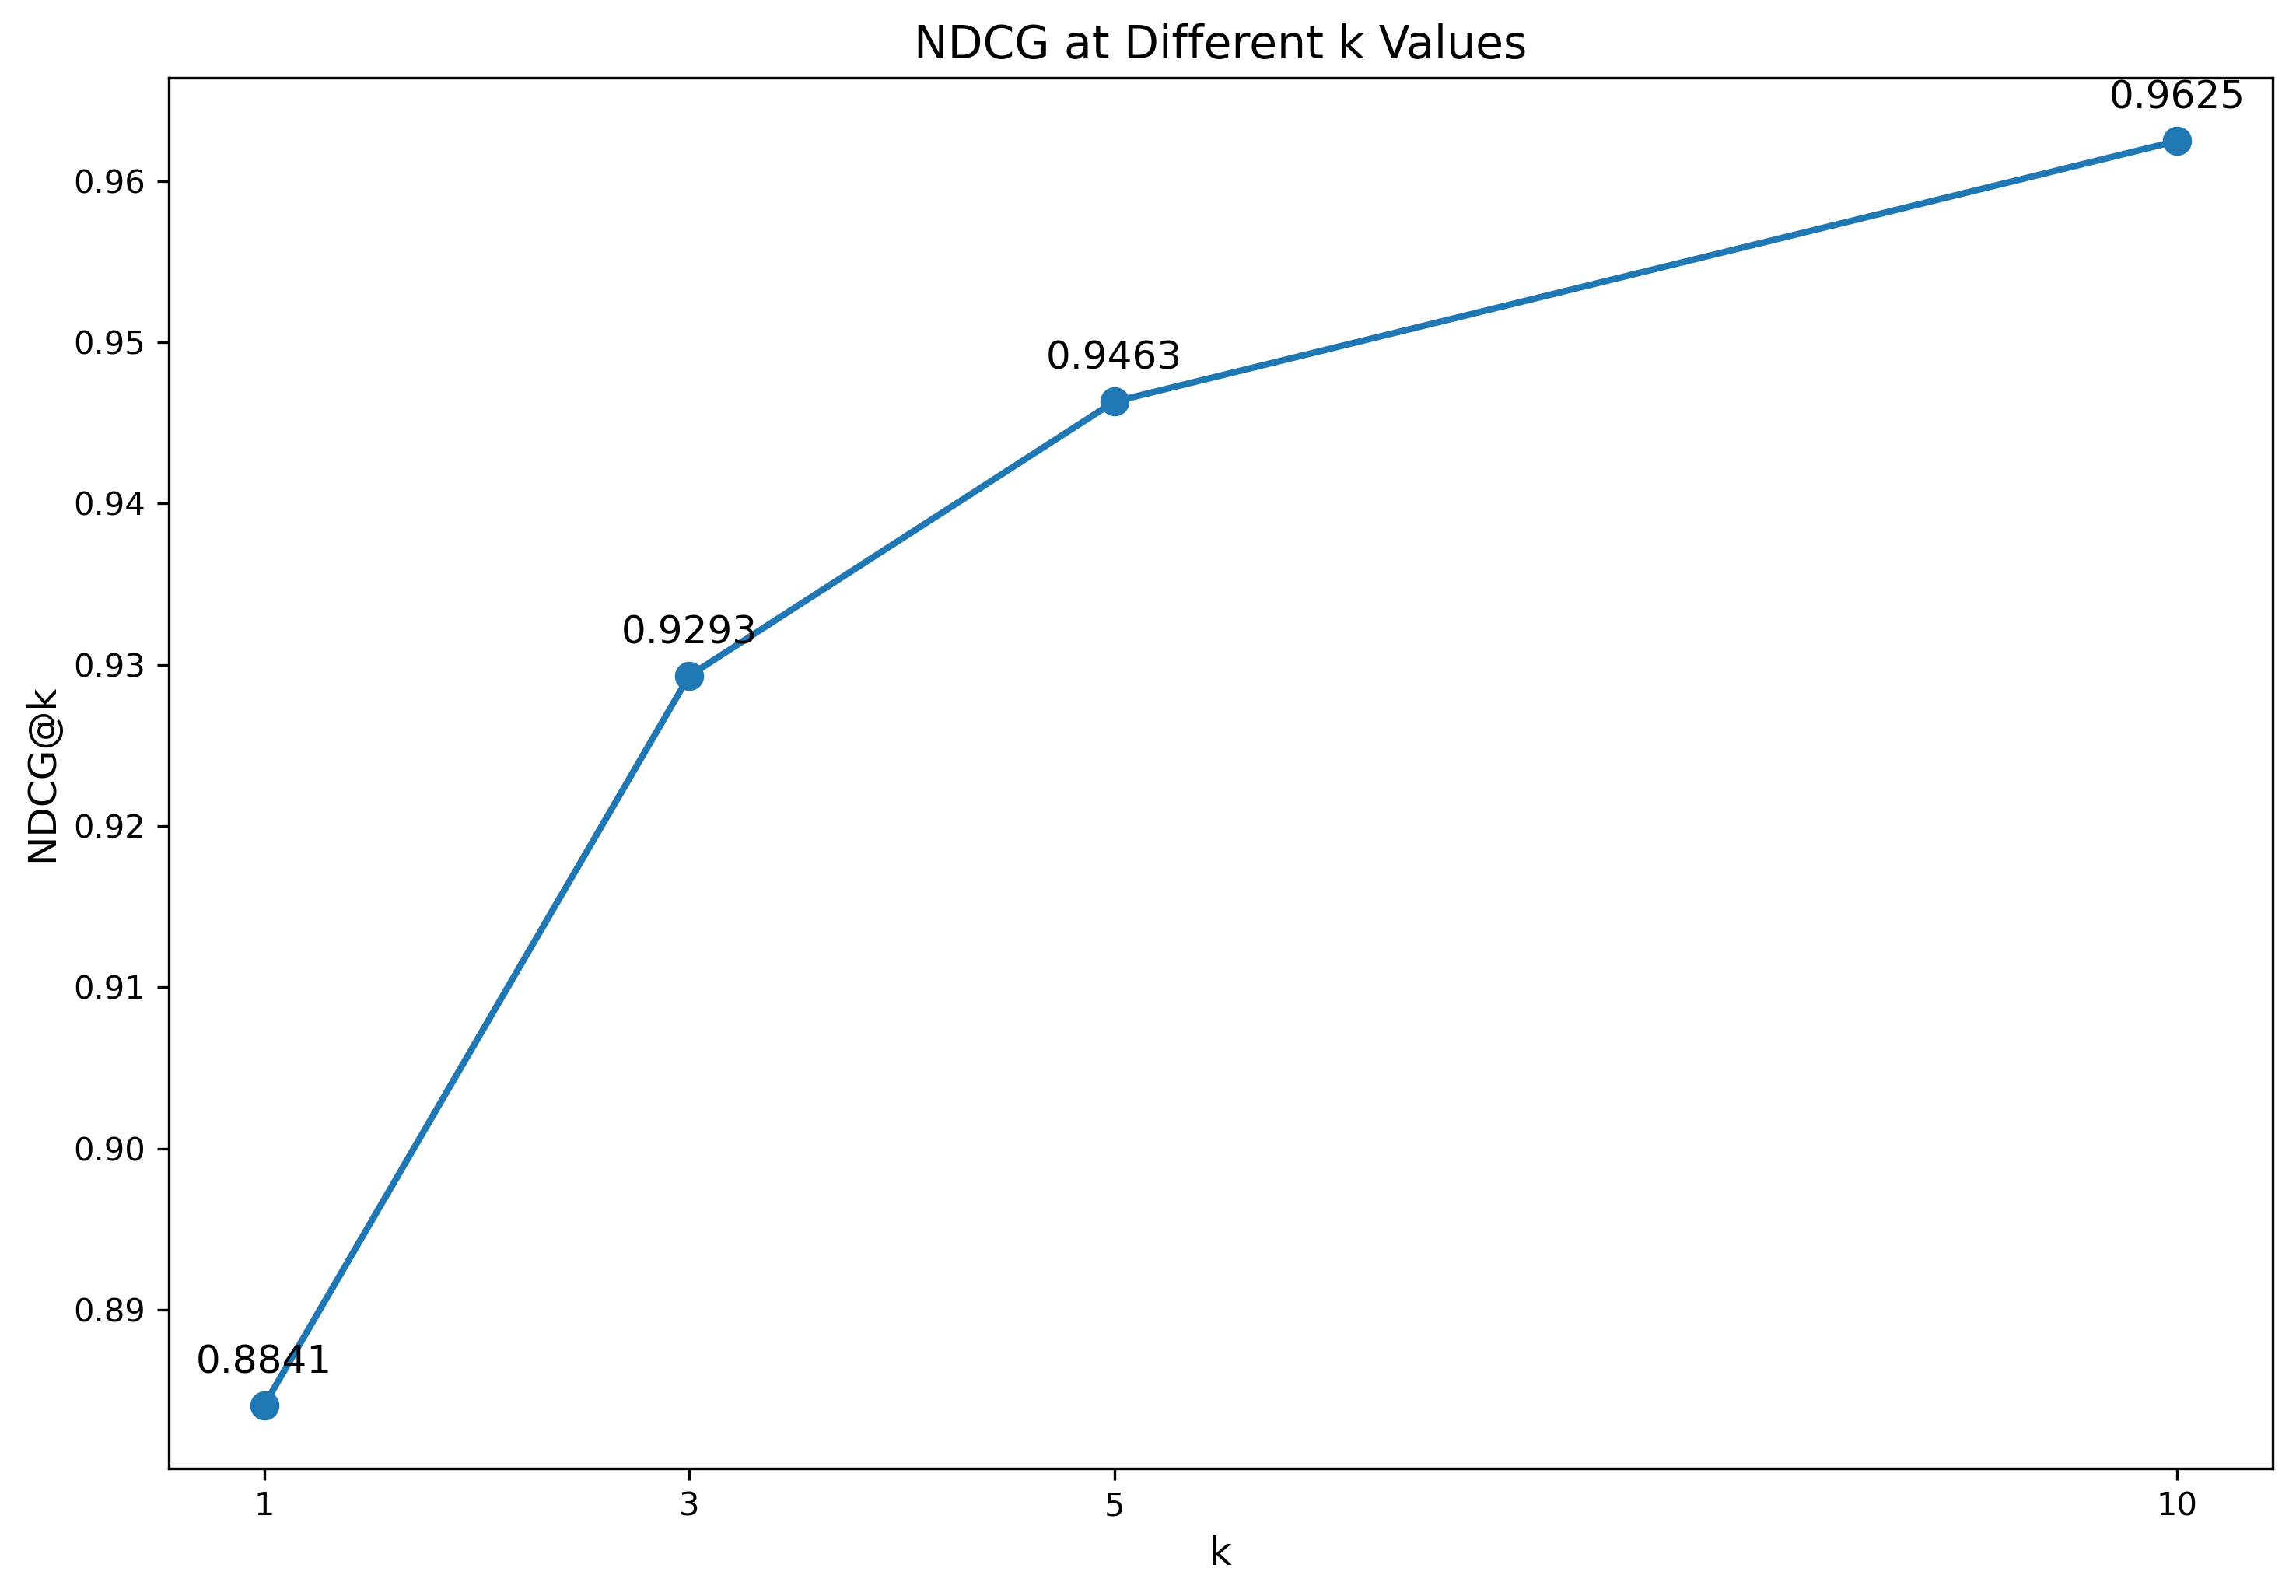


Model saved to:
  - c:\Users\dmxocean\Desktop\synthesisOne\models\ranking\lgbm_ranker_model.pkl
  - c:\Users\dmxocean\Desktop\synthesisOne\models\ranking\lgbm_ranker_model.txt

Results saved to:
  - Metrics: c:\Users\dmxocean\Desktop\synthesisOne\results\ranking\metrics.json
  - Feature importance: c:\Users\dmxocean\Desktop\synthesisOne\results\ranking\plots\feature_importance.png
  - Learning curve: c:\Users\dmxocean\Desktop\synthesisOne\results\ranking\plots\learning_curve.png
  - NDCG curve: c:\Users\dmxocean\Desktop\synthesisOne\results\ranking\plots\ndcg_curve.png


In [10]:
if model_trained and evaluation_complete:
    try:
        print("Saving model and generating visualizations...")
        
        # Save model and metrics
        save_model_and_metrics(
            model, training_history, metrics, X_train.columns.tolist(), config
        )
        
        # Generate visualizations
        generate_visualizations(
            model, training_history, metrics, X_train.columns.tolist()
        )
        
        print("\nModel saved to:")
        print(f"  - {os.path.join(PATH_MODEL_DIR, 'lgbm_ranker_model.pkl')}")
        print(f"  - {os.path.join(PATH_MODEL_DIR, 'lgbm_ranker_model.txt')}")
        
        print("\nResults saved to:")
        print(f"  - Metrics: {os.path.join(PATH_RESULTS_DIR, 'metrics.json')}")
        print(f"  - Feature importance: {os.path.join(PATH_PLOTS_DIR, 'feature_importance.png')}")
        print(f"  - Learning curve: {os.path.join(PATH_PLOTS_DIR, 'learning_curve.png')}")
        print(f"  - NDCG curve: {os.path.join(PATH_PLOTS_DIR, 'ndcg_curve.png')}")
        
    except Exception as e:
        print(f"Error saving model and visualizations: {str(e)}")
else:
    print("Cannot save model as training or evaluation failed")

## Performance Analysis

Analyzing model performance by group size...
Small groups (<=5 translators): 447 groups, avg NDCG@5: 0.5875
Medium groups (6-15 translators): 1633 groups, avg NDCG@5: 0.7770
Large groups (>15 translators): 77432 groups, avg NDCG@5: 0.9520


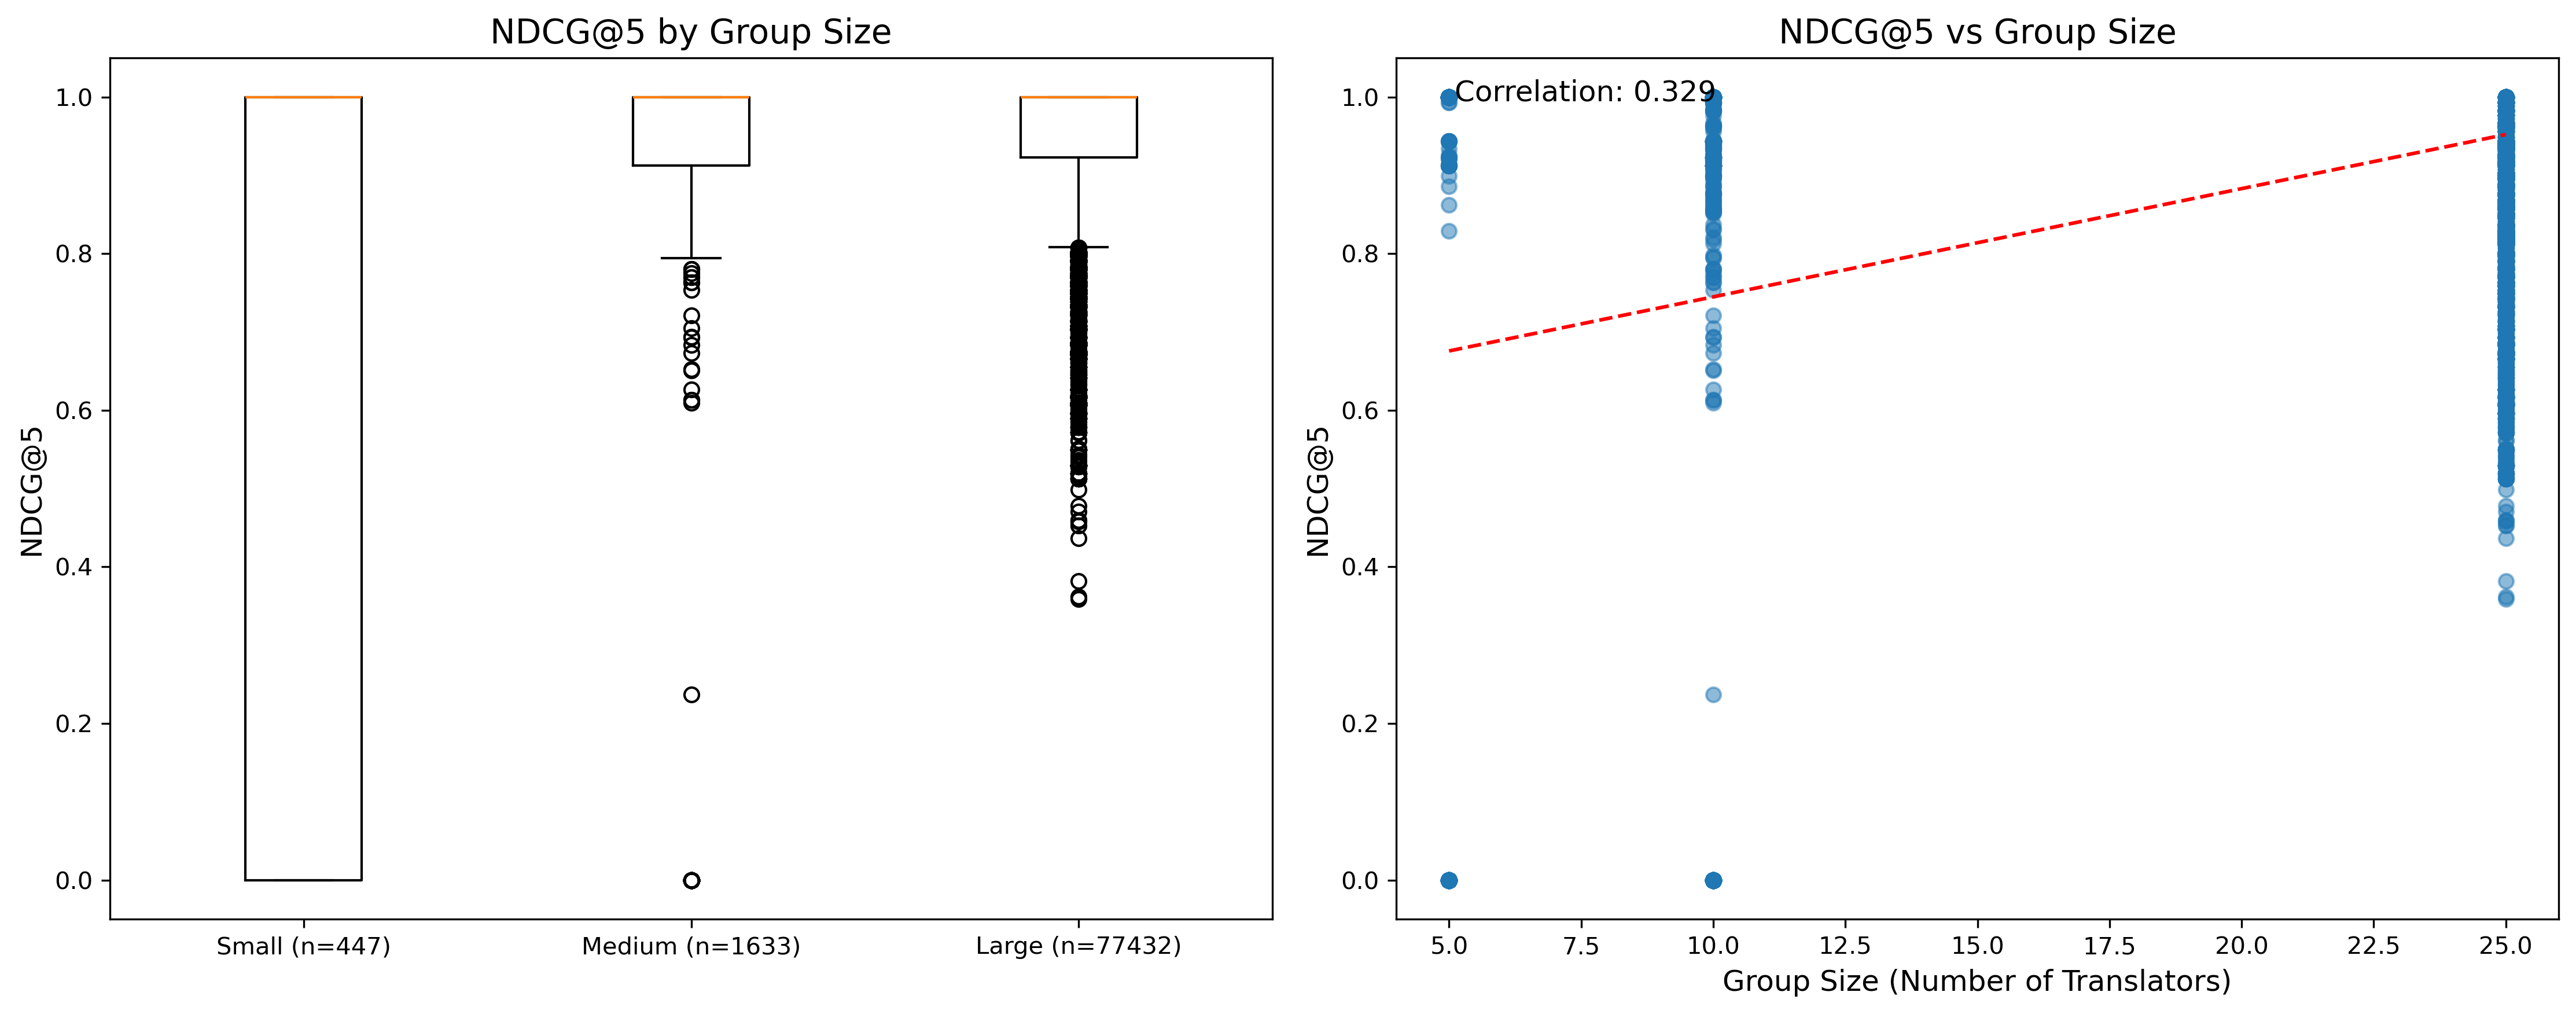

In [11]:
if model_trained and evaluation_complete:
    analyze_performance_by_group_size(model, X_test, relevance_test, groups_test)
else:
    print("Model or test data not available. Please train and evaluate the model first")

## Compare with Random Baseline

Comparing model performance with random baseline...

Performance comparison (NDCG@k):
k     Model      Random     Improvement    

1     0.8841     0.2301        284.27%
3     0.9293     0.2787        233.48%
5     0.9463     0.3120        203.29%
10    0.9625     0.3866        148.94%


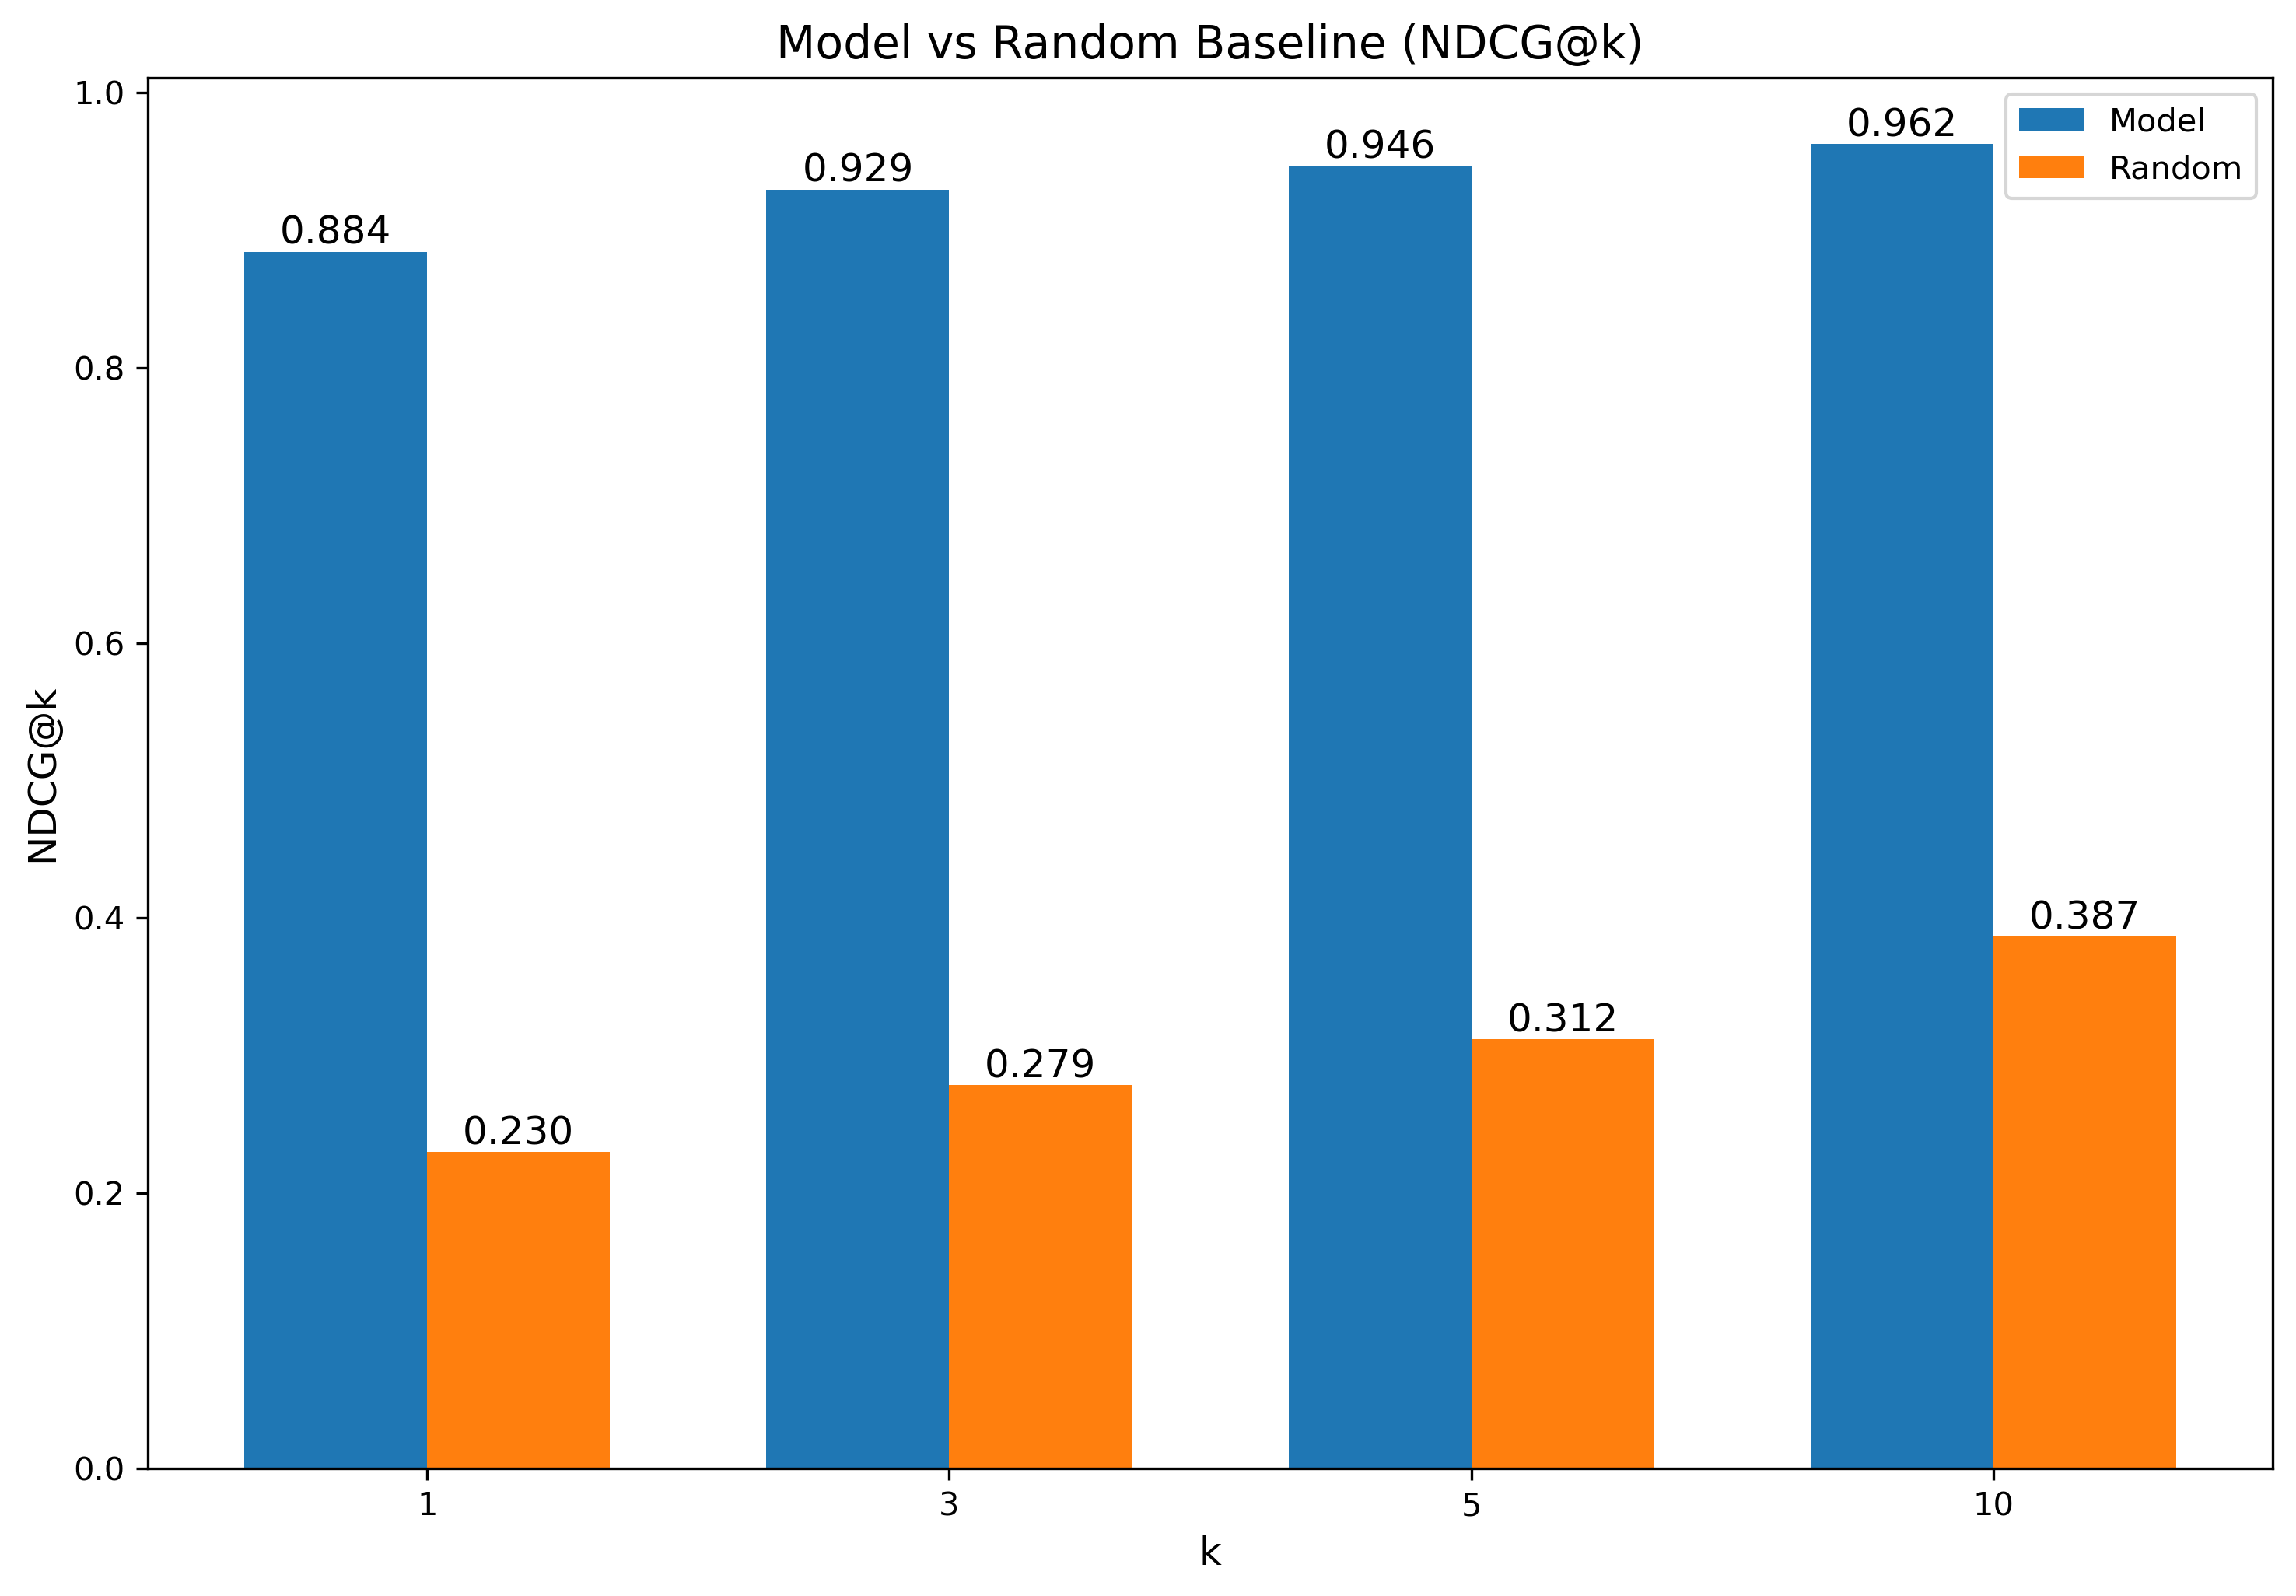

In [12]:
compare_with_random_baseline(model, X_test, relevance_test, groups_test)

## Model Inference Example

In [13]:
# Create sample tasks for inference
sample_tasks = pd.DataFrame({
    'PROJECT_ID': [220901, 220901, 220902],
    'PM': ['JDM', 'JDM', 'SAB'],
    'TASK_ID': [11230500, 11230501, 11230502],
    'START': ['2025-05-20 09:00:00', '2025-05-20 14:00:00', '2025-05-21 10:00:00'],
    'END': ['2025-05-22 17:00:00', '2025-05-21 18:00:00', '2025-05-23 15:00:00'],
    'TASK_TYPE': ['Translation', 'Proofreading', 'Engineering'],
    'SOURCE_LANG': ['English', 'German', 'English'],
    'TARGET_LANG': ['Spanish (Iberian)', 'French', 'German'],
    'FORECAST': [3.5, 2.0, 5.0],
    'COST': [59.5, 40.0, 85.0],
    'MANUFACTURER': ['Respiro Dynamics', 'SunTech', 'Biomedical Inc'],
    'MANUFACTURER_SECTOR': ['Information Technology', 'Health Care', 'Health Care']
})

sample_tasks['START'] = pd.to_datetime(sample_tasks['START'])
sample_tasks['END'] = pd.to_datetime(sample_tasks['END'])

print("Sample tasks for inference (with all required columns):")
print(sample_tasks.to_string())

Sample tasks for inference (with all required columns):
   PROJECT_ID   PM   TASK_ID               START                 END     TASK_TYPE SOURCE_LANG        TARGET_LANG  FORECAST  COST      MANUFACTURER     MANUFACTURER_SECTOR
0      220901  JDM  11230500 2025-05-20 09:00:00 2025-05-22 17:00:00   Translation     English  Spanish (Iberian)       3.5  59.5  Respiro Dynamics  Information Technology
1      220901  JDM  11230501 2025-05-20 14:00:00 2025-05-21 18:00:00  Proofreading      German             French       2.0  40.0           SunTech             Health Care
2      220902  SAB  11230502 2025-05-21 10:00:00 2025-05-23 15:00:00   Engineering     English             German       5.0  85.0    Biomedical Inc             Health Care


In [14]:
if model_trained:
    print("\nRunning inference to get actual translator predictions...")
    try:
        # Run inference to get translator recommendations
        translator_recommendations = run_inference(sample_tasks, top_k=10)
        
        # Display detailed recommendations for each task
        print("\nActual Translator Predictions:")
        for task_id, recommendations in translator_recommendations.items():
            # Get task details
            task_info = sample_tasks[sample_tasks['TASK_ID'] == task_id].iloc[0]
            
            print(f"Task ID: {task_id}")
            print(f"Project: {task_info['PROJECT_ID']} (PM: {task_info['PM']})")
            print(f"Type: {task_info['TASK_TYPE']}")
            print(f"Languages: {task_info['SOURCE_LANG']} -> {task_info['TARGET_LANG']}")
            print(f"Duration: {task_info['FORECAST']} hours")
            print(f"Cost: ${task_info['COST']}")
            print(f"Client: {task_info['MANUFACTURER']} ({task_info['MANUFACTURER_SECTOR']})")
            
            print(f"\nTop 10 Recommended Translators:")
            print(f"{'Rank':<6}{'Translator ID':<15}{'Score':<12}")
            
            for rank, (translator, score) in enumerate(recommendations, 1):
                print(f"{rank:<6}{translator:<15}{score:<12.4f}")
                
    except Exception as e:
        print(f"Error during inference: {str(e)}")
else:
    print("\nModel not available for inference. Please train the model first")


Running inference to get actual translator predictions...

Actual Translator Predictions:
Task ID: 11230500
Project: 220901 (PM: JDM)
Type: Translation
Languages: English -> Spanish (Iberian)
Duration: 3.5 hours
Cost: $59.5
Client: Respiro Dynamics (Information Technology)

Top 10 Recommended Translators:
Rank  Translator ID  Score       
1     Usula          3.7643      
2     Salomon Kimberly2.5938      
3     Alejandro      1.4692      
4     Sara           1.3584      
5     Dimas Rafael   1.1814      
6     Juan Rafael    1.1197      
7     Amaro          1.0072      
8     David Antonio  0.9771      
9     Roberto        0.9046      
10    Artemio Ramon  0.9002      
Task ID: 11230501
Project: 220901 (PM: JDM)
Type: Proofreading
Languages: German -> French
Duration: 2.0 hours
Cost: $40.0
Client: SunTech (Health Care)

Top 10 Recommended Translators:
Rank  Translator ID  Score       
1     Chantal        -3.2516     
2     Alice          -3.8263     
Task ID: 11230502
Project: 22

## Batch Inference Example

In [15]:
# Create a batch of tasks
batch_tasks_data = [
    [220901, 'JDM', 11230500, '2025-05-20 09:00:00', '2025-05-22 17:00:00', 'Translation', 'English', 'Spanish (Iberian)', 3.5, 59.5, 'Respiro Dynamics', 'Information Technology'],
    [220901, 'JDM', 11230501, '2025-05-20 14:00:00', '2025-05-21 18:00:00', 'Proofreading', 'German', 'French', 2.0, 40.0, 'SunTech', 'Health Care'],
    [220902, 'SAB', 11230502, '2025-05-21 10:00:00', '2025-05-23 15:00:00', 'Engineering', 'English', 'German', 5.0, 85.0, 'Biomedical Inc', 'Health Care'],
    [220902, 'SAB', 11230503, '2025-05-21 13:00:00', '2025-05-22 17:00:00', 'Review', 'Spanish (Iberian)', 'English', 1.5, 30.0, 'TechCorp', 'Technology'],
    [220903, 'KMT', 11230504, '2025-05-22 08:00:00', '2025-05-24 17:00:00', 'Translation', 'French', 'Spanish (Iberian)', 4.0, 68.0, 'MedTech Solutions', 'Health Care'],
    [220903, 'KMT', 11230505, '2025-05-22 09:00:00', '2025-05-23 12:00:00', 'Proofreading', 'English', 'French', 2.5, 42.5, 'InnovateWorks', 'Consumer Discretionary'],
    [220904, 'RPN', 11230506, '2025-05-23 10:00:00', '2025-05-25 16:00:00', 'Translation', 'Italian', 'English', 3.0, 51.0, 'AutoParts GmbH', 'Manufacturing'],
    [220904, 'RPN', 11230507, '2025-05-23 14:00:00', '2025-05-24 18:00:00', 'Review', 'English', 'Spanish (Iberian)', 1.0, 17.0, 'FinanceGroup', 'Financials'],
    [220905, 'JDM', 11230508, '2025-05-24 09:00:00', '2025-05-26 17:00:00', 'Engineering', 'German', 'Italian', 6.0, 102.0, 'Pharma Ltd', 'Health Care'],
    [220905, 'JDM', 11230509, '2025-05-24 15:00:00', '2025-05-25 17:00:00', 'Proofreading', 'Spanish (Iberian)', 'German', 2.0, 34.0, 'ConsumerGoods Co', 'Consumer Staples']
]

columns = ['PROJECT_ID', 'PM', 'TASK_ID', 'START', 'END', 'TASK_TYPE', 
           'SOURCE_LANG', 'TARGET_LANG', 'FORECAST', 'COST', 
           'MANUFACTURER', 'MANUFACTURER_SECTOR']

batch_tasks = pd.DataFrame(batch_tasks_data, columns=columns)

batch_tasks['START'] = pd.to_datetime(batch_tasks['START'])
batch_tasks['END'] = pd.to_datetime(batch_tasks['END'])

print("Batch of tasks for inference (production format):")
print(batch_tasks.to_string())

Batch of tasks for inference (production format):
   PROJECT_ID   PM   TASK_ID               START                 END     TASK_TYPE        SOURCE_LANG        TARGET_LANG  FORECAST   COST       MANUFACTURER     MANUFACTURER_SECTOR
0      220901  JDM  11230500 2025-05-20 09:00:00 2025-05-22 17:00:00   Translation            English  Spanish (Iberian)       3.5   59.5   Respiro Dynamics  Information Technology
1      220901  JDM  11230501 2025-05-20 14:00:00 2025-05-21 18:00:00  Proofreading             German             French       2.0   40.0            SunTech             Health Care
2      220902  SAB  11230502 2025-05-21 10:00:00 2025-05-23 15:00:00   Engineering            English             German       5.0   85.0     Biomedical Inc             Health Care
3      220902  SAB  11230503 2025-05-21 13:00:00 2025-05-22 17:00:00        Review  Spanish (Iberian)            English       1.5   30.0           TechCorp              Technology
4      220903  KMT  11230504 2025-05-22 08:00

In [16]:
if model_trained:
    print("\nRunning batch inference for all tasks...")
    try:
        # Run batch inference
        batch_recommendations = run_inference(batch_tasks, top_k=5)
        
        print("\nBatch Inference Results Summary:")
        
        results_summary = []
        
        for index, row in batch_tasks.iterrows():
            task_id = row['TASK_ID']
            
            if task_id in batch_recommendations:
                recommendations = batch_recommendations[task_id]
                top_translator = recommendations[0][0] if recommendations else 'None'
                top_score = recommendations[0][1] if recommendations else 0.0
                
                summary_row = {
                    'Task_ID': task_id,
                    'Project': row['PROJECT_ID'],
                    'PM': row['PM'],
                    'Type': row['TASK_TYPE'],
                    'Languages': f"{row['SOURCE_LANG'][:3]}->{row['TARGET_LANG'][:3]}",
                    'Top_Translator': top_translator,
                    'Score': f"{top_score:.3f}",
                    'Num_Candidates': len(recommendations)
                }
                results_summary.append(summary_row)
        
        summary_df = pd.DataFrame(results_summary)
        print(summary_df.to_string(index=False))
        
        # Show predictions
        print("\nDetailed Predictions :")
        for i, (task_id, recommendations) in enumerate(batch_recommendations.items()):
            if i >= 3:  # Only show some examples
                break
                
            task_info = batch_tasks[batch_tasks['TASK_ID'] == task_id].iloc[0]
            print(f"\n{'-'*40}")
            print(f"Task {task_id}: {task_info['SOURCE_LANG']} > {task_info['TARGET_LANG']} ({task_info['TASK_TYPE']})")
            print("Recommended Translators:")
            
            for rank, (translator, score) in enumerate(recommendations[:5], 1):
                print(f"  {rank}. {translator} (score: {score:.4f})")
                
    except Exception as e:
        print(f"Error during batch inference: {str(e)}")
else:
    print("\nModel not available for batch inference. Please train the model first")


Running batch inference for all tasks...

Batch Inference Results Summary:
 Task_ID  Project  PM         Type Languages  Top_Translator  Score  Num_Candidates
11230500   220901 JDM  Translation  Eng->Spa           Usula  3.733               5
11230501   220901 JDM Proofreading  Ger->Fre         Chantal -3.275               2
11230502   220902 SAB  Engineering  Eng->Ger          Victor  1.640               5
11230503   220902 SAB       Review  Spa->Eng Ariadna Laurina  0.177               5
11230504   220903 KMT  Translation  Fre->Spa Almudena Fiamma  4.198               5
11230505   220903 KMT Proofreading  Eng->Fre        Alphonse  0.144               5
11230506   220904 RPN  Translation  Ita->Eng            Aino -2.504               3
11230507   220904 RPN       Review  Eng->Spa     Juan Rafael -0.453               5
11230508   220905 JDM  Engineering  Ger->Ita         Alessio -0.354               3
11230509   220905 JDM Proofreading  Spa->Ger  Primo Almudena -0.287               5
